# 集成学习

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mlp
import seaborn as sns
import re, pip

In [2]:
for package in [sklearn,mlp,np,pd,sns,pip]:
    print(re.findall("([^']*)",str(package))[2],package.__version__)

sklearn 1.5.0
matplotlib 3.7.2
numpy 1.26.4
pandas 2.2.2
seaborn 0.12.2
pip 23.0.1


In [3]:
#pip install --upgrade scikit-learn
#conda update scikit-learn

目录

一 Boosting方法的基本思想<br>
&emsp;1 Bagging pk Boosting<br>
&emsp;2 Boosting算法的基本元素与基本流程<br>
&emsp;3 sklearn中的boosting算法<br>
二 AdaBoost<br>
&emsp;1 AdaBoost的基本参数与损失函数<br>
&emsp;&emsp;1.1 n_estimators<br>
&emsp;&emsp;1.2 learning_rate<br>
&emsp;&emsp;1.3 algorithm与loss<br>
&emsp;2 原理进阶：Adaboost回归的求解流程<br>

# 一 Boosting方法的基本思想

在集成学习的“弱分类器集成”领域，除了降低方差来降低整体泛化误差的装袋法Bagging，还有专注于**降低整体偏差**来降低泛化误差的提升法Boosting。相比起操作简单、大道至简的Bagging算法，Boosting算法在操作和原理上的难度都更大，但由于专注于偏差降低，Boosting算法们在模型效果方面的突出表现制霸整个弱分类器集成的领域。当代知名的Boosting算法当中，Xgboost，LightGBM与Catboost都是机器学习领域最强大的强学习器，Boosting毫无疑问是当代机器学习领域最具统治力的算法领域。

- **Boosting PK Bagging**

||装袋法 Bagging|提升法 Boosting|
|-|-|-|
|弱评估器|**相互独立**，并行构建|**相互关联**，按顺序依次构建<br>先建弱分类器的预测效果影响后续模型的建立|
|建树前的抽样方式|样本有放回抽样<br>特征无放回抽样|样本有放回抽样<br>特征无放回抽样<br>先建弱分类器的预测效果可能影响抽样细节|
|集成的结果|回归平均<br>分类众数|每个算法**具有自己独特的规则**，一般来说：<br>(1) 表现为某种分数的加权平均<br>(2) 使用输出函数|
|目标|**降低方差**<br>提高模型整体的稳定性来提升泛化能力<br>本质是从“平均”这一数学行为中获利|**降低偏差**<br>提高模型整体的精确度来提升泛化能力<br>相信众多弱分类器叠加后可以等同于强学习器|
|单个评估器容易<br>过拟合的时候|具有一定的抗过拟合能力|具有一定的抗过拟合能力|
|单个评估器的效力<br>比较弱的时候|可能失效|大概率会提升模型表现|
|代表算法|随机森林|梯度提升树，Adaboost|

![RF2](https://pictes.oss-cn-beijing.aliyuncs.com/%E5%BE%AE%E8%AF%BE%20-%20sklearn/RFC/RF2.png)

在以随机森林为代表的Bagging算法中，我们一次性建立多个平行独立的弱评估器，并让所有评估器并行运算。在Boosting集成算法当中，我们逐一建立多个弱评估器（基本是决策树），并且下一个弱评估器的建立方式依赖于上一个弱评估器的评估结果，最终综合多个弱评估器的结果进行输出，因此Boosting算法中的弱评估器之间不仅不是相互独立的、反而是强相关的，同时Boosting算法也不依赖于弱分类器之间的独立性来提升结果，这是Boosting与Bagging的一大差别。如果说Bagging不同算法之间的核心区别在于靠以不同方式实现“独立性”（随机性），**那Boosting的不同算法之间的核心区别就在于上一个弱评估器的评估结果具体如何影响下一个弱评估器的建立过程**。

与Bagging算法中统一的回归求平均、分类少数服从多数的输出不同，Boosting算法在结果输出方面表现得十分多样。早期的Boosting算法的输出一般是最后一个弱评估器的输出，当代Boosting算法的输出都会考虑整个集成模型中全部的弱评估器。**一般来说，每个Boosting算法会其以独特的规则自定义集成输出的具体形式**，但对大部分算法而言，集成算法的输出结果往往是**关于弱评估器的某种结果的加权平均**，其中权重的求解是boosting领域中非常关键的步骤。

- **Boosting算法的基本元素与基本流程**

基于上面所明确的“降低偏差”、“逐一建树”、以及“以独特规则输出结果”的三大特色，我们可以确立任意boosting算法的三大基本元素以及boosting算法自适应建模的基本流程：

- 损失函数$L(x,y)$ ：用以衡量模型预测结果与真实结果的差异
- 弱评估器$f(x)$ ：（一般为）决策树，不同的boosting算法使用不同的建树过程
- 综合集成结果$H(x)$：即集成算法具体如何输出集成结果

这三大元素将会贯穿所有我们即将学习的boosting算法，我们会发现几乎所有boosting算法的原理都围绕这三大元素构建。在此三大要素基础上，所有boosting算法都遵循以下流程进行建模：

---
**<font color="green"><center>依据上一个弱评估器$f(x)_{t-1}$的结果，计算损失函数$L(x,y)$，
    <br>并使用$L(x,y)$自适应地影响下一个弱评估器$f(x)_t$的构建。<br>集成模型输出的结果，受到整体所有弱评估器$f(x)_0$ ~ $f(x)_T$的影响。</center></font>**
---

正如之前所言，Boosting算法之间的不同之处就在于使用不同的方式来**影响**后续评估器的构建。无论boosting算法表现出复杂或简单的流程，其核心思想一定是围绕上面这个流程不变的。

- **sklearn中的boosting算法**

在sklearn当中，我们可以接触到数个Boosting集成算法，包括Boosting入门算法**AdaBoost**，性能最稳定、奠定了整个Boosting效果基础的梯度提升树**GBDT**（Gradient Boosting Decision Tree），以及近几年才逐渐被验证有效的**直方提升树**（Hist Gradient Boosting Tree）。

在过去5年之间，除了sklearn，研究者们还创造了大量基于GBDT进行改造的提升类算法，这些算法大多需要从第三方库进行调用，例如极限提升树**XGBoost**（Extreme Gradient Boosting Tree），轻量梯度提升树**LightGBM**（Light Gradiant Boosting Machine），以及离散提升树**CatBoost**（Categorial Boosting Tree）。

|Boosting算法|库|集成类|
|:--:|:--:|:--:|
|ADB分类|sklearn|AdaBoostClassifer|
|ADB回归|sklearn|AdaBoostRegressor|
|梯度提升树分类|sklearn|GradientBoostingClassifier|
|梯度提升树回归|sklearn|GradientBoostingRegressor|
|直方提升树分类|sklearn|HistGraidientBoostingClassifier|
|直方提升树回归|sklearn|HistGraidientBoostingRegressor|
|极限提升树|第三方库xgboost|xgboost.train()|
|轻量梯度提升树|第三方库lightgbm|lightgbm.train()|
|离散提升树|第三方库catboost|catboost.train()|

在课程当中，我们会一一介绍以上所有算法的原理与用法。另外需要注意的是，周志华老师于2017年提出的深度森林算法既不是boosting也不是bagging，而是以深度学习的思路重新集成决策树之后得到的独特算法，可以算是模型融合的一部分。

# 二 AdaBoost

AdaBoost（Adaptive Boosting，自适应提升法）是当代boosting领域的开山鼻祖，它虽然不是首个实践boosting思想算法，却是首个成功将boosting思想发扬光大的算法。它的主要贡献在于实现了两个变化：

1、首次实现根据之前弱评估器的结果**自适应地**影响后续建模过程<br>
2、在Boosting算法中，首次实现考虑全部弱评估器结果的输出方式<br>

作为开山算法，AdaBoost的构筑过程非常简单：**首先，在全样本上建立一棵决策树，根据该决策树预测的结果和损失函数值，增加被预测错误的样本在数据集中的样本权重，并让加权后的数据集被用于训练下一棵决策树**。这个过程相当于有意地加重“难以被分类正确的样本”的权重，同时降低“容易被分类正确的样本”的权重，而将后续要建立的弱评估器的注意力引导到难以被分类正确的样本上。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021MachineLearning/Ensembles/Public/boostrap-fixed2.png)

在该过程中，上一棵决策树的的结果通过影响样本权重、即影响数据分布来影响下一棵决策树的建立，整个过程是自适应的。当全部弱评估器都被建立后，集成算法的输出$H(x)$等于所有弱评估器输出值的加权平均，加权所用的权重也是在建树过程中被自适应地计算出来的。

需要注意的是，虽然最初的原理较为简单，但近年来AdaBoost在已经发展出多个升级的版本（比如，**在建立每棵树之前，允许随机抽样特征，这使得Boosting中的决策树行为更加接近Bagging中的决策树**），而sklearn中使用了这些升级后的版本进行实现。幸运的是，这些实现并不影响我们对sklearn中的类的使用，对这些实现的具体过程感兴趣的小伙伴，可以在章节《2 原理进阶：AdaBoost的求解流程》中查看具体原理。

在sklearn中，AdaBoost既可以实现分类也可以实现回归，我们使用如下两个类来调用它们：

*class* `sklearn.ensemble.AdaBoostClassifier`(base_estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)

*class* `sklearn.ensemble.AdaBoostRegressor`(base_estimator=None, *, n_estimators=50, learning_rate=1.0, loss='linear', random_state=None)

不难发现，AdaBoost的参数非常非常少，在调用AdaBoost时我们甚至无需理解AdaBoost的具体求解过程。同时，ADB分类器与ADB回归器的参数也高度一致。在课程当中，我们将重点Boosting算法独有的参数，以及ADB分类与ADB回归中表现不一致的参数。

|参数|参数含义|
|:-:|:-:|
|**base_estimator**|弱评估器|
|n_estimators|集成算法中弱评估器的数量|
|**learning_rate**|迭代中所使用的学习率|
|**algorithm**（分类器专属）|用于指定分类ADB中使用的具体实现方法|
|**loss**（回归器专属）|用于指定回归ADB中使用的损失函数|
|random_state|用于控制每次建树之前随机抽样过程的随机数种子|

## 1 AdaBoost的基本参数与损失函数

In [4]:
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.datasets import load_digits

In [5]:
#用于分类的数据
data_c = load_digits()
X_c = data_c.data
y_c = data_c.target

In [6]:
X_c.shape

(1797, 64)

In [7]:
X_c

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [8]:
np.unique(y_c) #手写数字数据集，10分类

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
#用于回归的数据
data_r = pd.read_csv(r"..\datasets\House Price\train_encode.csv",index_col=0)
X_g = data_r.iloc[:,:-1]
y_g = data_r.iloc[:,-1]

In [10]:
X_g.shape

(1460, 80)

In [11]:
X_g.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


- 参数`base_estimator`，属性`base_estimator_`与`estimators_`

`base_estimator`是规定AdaBoost中使用弱评估器的参数。与对弱评估器有严格要求的Bagging算法不同，boosting算法通过降低偏差来降低整体泛化误差，因此可以使用任意弱评估器，且这些弱评估器往往被假设成非常弱小的评估器。当然了，默认的弱评估器还是决策树。在sklearn中，**ADB分类器的默认弱评估器是最大深度为1的“树桩”，ADB回归器的默认评估器是最大深度为3的“树苗”**，弱评估器本身基本不具备判断能力。而回归器中树深更深是因为boosting算法中回归任务往往更加复杂。在传统ADB理论当中，一般认为AdaBoost中的弱分类器为最大深度为1的树桩，但现在我们也可以自定义某种弱评估器来进行输入。

当模型建好之后，我们可以使用属性`base_estimator_`来查看当前弱评估器，同时也可以使用`estimators_`来查看当前集成模型中所有弱评估器的情况：

- 建立集成算法，调用其中的弱评估器

In [12]:
#建立ADB回归器和分类器
clf = ABC(n_estimators=3).fit(X_c,y_c)
reg = ABR(n_estimators=3).fit(X_g,y_g)

C:\Users\18269\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [13]:
clf.estimator_

DecisionTreeClassifier(max_depth=1)

In [14]:
reg.estimator_

DecisionTreeRegressor(max_depth=3)

In [15]:
reg.estimators_

[DecisionTreeRegressor(max_depth=3, random_state=1934520582),
 DecisionTreeRegressor(max_depth=3, random_state=849171036),
 DecisionTreeRegressor(max_depth=3, random_state=707118322)]

当AdaBoost完成分类任务时，弱评估器是分类树，当AdaBoost完成回归任务时，弱评估器是回归树，这一点与之后的Boosting算法们有较大的区别。

- 自建弱评估器

In [16]:
base_estimator = DTC(max_depth=10,max_features=30)

In [17]:
clf = ABC(estimator = base_estimator, n_estimators=3).fit(X_c,y_c)

C:\Users\18269\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [18]:
clf.estimator_

DecisionTreeClassifier(max_depth=10, max_features=30)

In [19]:
clf.estimators_

[DecisionTreeClassifier(max_depth=10, max_features=30, random_state=597200532),
 DecisionTreeClassifier(max_depth=10, max_features=30, random_state=904449205),
 DecisionTreeClassifier(max_depth=10, max_features=30, random_state=954344131)]

注意，为了保证集成算法中的树不一致，AdaBoost会默认消除我们填写在弱评估器中的random_state：

In [20]:
base_estimator = DTC(max_depth=10,max_features=30,random_state=1412)

In [21]:
clf = ABC(estimator = base_estimator, n_estimators=3).fit(X_c,y_c)

C:\Users\18269\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [30]:
clf.estimators_

[DecisionTreeClassifier(max_depth=10, max_features=30, random_state=1655098088),
 DecisionTreeClassifier(max_depth=10, max_features=30, random_state=990525492),
 DecisionTreeClassifier(max_depth=10, max_features=30, random_state=578475871)]

- 参数`learning_rate`

在Boosting集成方法中，集成算法的输出$H(x)$往往都是多个弱评估器的输出结果的加权平均结果。但$H(x)$并不是在所有树建好之后才统一加权求解的，而是在算法逐渐建树的过程当中就随着迭代不断计算出来的。例如，对于样本$x_i$，集成算法当中一共有$T$棵树（也就是参数`n_estimators`的取值），现在正在建立第$t$个弱评估器，则第$t$个弱评估器上$x_i$的结果可以表示为$f_t(x_i)$。假设整个Boosting算法对样本$x_i$输出的结果为$H(x_i)$，则该结果一般可以被表示为t=1~t=T过程当中，所有弱评估器结果的加权求和：

$$H(x_i) =  \sum_{t=1}^T\phi_tf_t(x_i)$$

其中，$\phi_t$为第t棵树的权重。对于第$t$次迭代来说，则有：

$$H_t(x_i) = H_{t-1}(x_i) + \phi_tf_t(x_i)$$

在这个一般过程中，每次将本轮建好的决策树加入之前的建树结果时，可以在权重$\phi$前面增加参数$\color{red}\eta$，表示为第t棵树加入整体集成算法时的学习率，对标参数`learning_rate`。

$$H_t(x_i) = H_{t-1}(x_i) + \boldsymbol{\color{red}\eta} \phi_tf_t(x_i)$$

该学习率参数控制Boosting集成过程中$H(x_i)$的增长速度，是相当关键的参数。当学习率很大时，$H(x_i)$增长得更快，我们所需的n_estimators更少，当学习率较小时，$H(x_i)$增长较慢，我们所需的n_estimators就更多，因此boosting算法往往会需要在n_estimators与learning_rate当中做出权衡（以XGBoost算法为例）。

![](https://pictes.oss-cn-beijing.aliyuncs.com/%E5%BE%AE%E8%AF%BE%20-%20sklearn/week%2011%20XGBoost/eta.PNG)

需要注意的是，**以上式子为boosting算法中计算方式的一般规则，并不是具体到AdaBoost或任意Boosting集成算法的具体公式**。

- 参数`algorithm`与`loss`

参数`algorithm`与`loss`是boosting算法中非常常见的，分类器与回归器展示出不同参数的情况。正如之前提到的，虽然AdaBoost算法的原理简单，但是在近几年已经发展出了多种不同的算法实践手段，而参数`algorithm`与`loss`正是用来控制算法实践手段的关键参数，其中`algorithm`控制具体的实践算法，`loss`控制该实践算法中所使用的具体损失函数。

> - `algorithm`

首先，参数`algorithm`是针对分类器设置的参数，其中备选项有"SAMME"与"SAMME.R"两个字符串。这两个字符串分别代表了两种不同的、实现AdaBoost分类的手段：AdaBoost-SAMME与AdaBoost-SAMME.R。两者在数学流程上的区别并不大，只不过SAMME是基于算法输出的具体分类结果（例如-1，1，2）进行计算，而SAMME.R则是在SAMME基础上改进过后、基于弱分配器输出的概率值进行计算，两种方法都支持在AdaBoost上完成多分类任务，但SAMME.R往往能够得到更好的结果，因此sklearn中的默认值是SAMME.R，因此**sklearn中默认可以输入的base_estimators也需要是能够输出预测概率的弱评估器。实际在预测时，AdaBoost输出的$H(x)$也针对于某一类别的概率**。

需要注意的是，在分类器中，我们虽然被允许选择算法，却不被允许选择算法所使用的损失函数，这是因为SAMME与SAMME.R使用了相同的损失函数：二分类指数损失（Exponential Loss Function）与多分类指数损失（Multi-class Exponential loss function）。

**二分类指数损失**——
$$L(H(x),y) = e^{-yH^*(x)}$$<br>
其中y为真实分类，$H^*(x)$则是从集成算法输出的概率结果$H(x)$转换来的向量。转换规则如下：

$$H^*(x)=
\begin{cases}
1& if \ H(x)>0.5 \\
-1& if\  H(x) < 0.5
\end{cases}$$

在sklearn当中，由于$H(x)$是概率值，因此需要转换为$H^*(x)$，如果在其他实现AdaBoost的算法库中，$H(x)$输出直接为预测类别，则可以不执行转换流程。

**根据指数损失的特殊性质，二分类状况下的类别取值只能为-1或1**，因此$y$的取值只能为-1或1。当算法预测正确时，$yH^*(x)$的符号为正，则在函数$e^{-x}$上损失很小。当算法预测错误时，$yH^*(x)$的符号为负，则在函数$e^{-x}$上损失较大。二分类指数损失是AdaBoost最经典的损失函数，它在数学推导上的有效性以及在实践过程中很强的指导性让其沿用至今。

![](https://www.tf.uni-kiel.de/matwis/amat/mw1_ge/kap_5/illustr/exponential1com.png)

**多分类指数损失**——

$$
\begin{aligned}
L(H(x),y) &=exp \left( -\frac{1}{K}\boldsymbol{y^* · H^*(x)} \right) \\ 
& = exp \left( -\frac{1}{K}(y^{*1}H^{*1}(x)+y^{*2}H^{*2}(x) \ + \  ... + y^{*k}H^{*k}(x)) \right)
\end{aligned}
$$<br>
其中，$K$为总类别数，如四分类[0,1,2,3]的情况时，$K=4$，$\boldsymbol{y^*}$与$\boldsymbol{H^*(x)}$都是根据多分类具体情况、以及集成算法实际输出$H(x)$转化出的向量，其中$y^{*1}$与$H^{*1}(x)$的上标1都表示当前类别。

在二分类算法中，算法会直接针对二分类中的**其中一个类别**输出概率，因为在二分类中$P(Y=1) = 1 - P(Y=-1)$，所以只计算出一类的概率即可判断预测的标签。但在多分类算法中，算法必须针对所有可能的取值类型都输出概率，**才能够从中找出最大概率所对应的预测标签**。因此在集成算法中，我们对进行多分类预测时，会得到如下的表格：

In [36]:
#多分类预测
clf = DTC(max_depth=2).fit(X_c,y_c)

#多分类预测输出的概率结果，取前5个样本
pd.DataFrame(clf.predict_proba(X_c)).iloc[:5,:]

,0,1,2,3,4,5,6,7,8,9
0,0.909574,0.000000,0.010638,0.000000,0.031915,0.031915,0.015957,0.000000,0.000000,0.000000
1,0.003781,0.131380,0.120038,0.157845,0.134216,0.011342,0.003781,0.163516,0.158790,0.115312
2,0.003781,0.131380,0.120038,0.157845,0.134216,0.011342,0.003781,0.163516,0.158790,0.115312
3,0.000000,0.092672,0.099138,0.032328,0.071121,0.312500,0.370690,0.012931,0.006466,0.002155
4,0.909574,0.000000,0.010638,0.000000,0.031915,0.031915,0.015957,0.000000,0.000000,0.000000


每一行对应一个样本，每一列则对应该样本的预测标签为某一类别的概率，以上表格就是5个样本在10分类情况下得出的概率表格，**而每一个样本的10个概率中，最大概率所对应的类别就是预测类别**。而这一转换可以由函数argmax完成。argmax会取出最大值所对应的索引，刚好也就是最大概率所对应的预测标签。

In [37]:
np.argmax(pd.DataFrame(clf.predict_proba(X_c)).iloc[0,:])

0

In [38]:
np.argmax(pd.DataFrame(clf.predict_proba(X_c)).iloc[1,:])

7

In [39]:
np.argmax(pd.DataFrame(clf.predict_proba(X_c)).iloc[3,:])

6

对一棵决策树我们会输出k个概率，对于boosting集成中的每一棵树，在任意样本上都会得到$f^{c=0}(x)$、$f^{c=1}(x)$、$f^{c=2}(x)$……数个不同的结果。在集成算法当中，每个样本在第t次建树过程中，都会生成针对于不同类别的结果：

$$H_{t}^0(x_i) = H_{t-1}^0(x_i) + \phi_tf_t^0(x_i)$$<br>
$$H_{t}^1(x_i) = H_{t-1}^1(x_i) + \phi_tf_t^1(x_i)$$<br>
$$H_{t}^2(x_i) = H_{t-1}^2(x_i) + \phi_tf_t^2(x_i)$$<br>
$$……$$
$$H_{t}^k(x_i) = H_{t-1}^k(x_i) + \phi_tf_t^k(x_i)$$<br>

因此，我们可以得到向量$[H^0(x),H^1(x),H^2(x),...,H^k(x)]$，表示当前集成算法计算出的、针对多个类别的概率（也是对全部弱分类器输出的、针对多个类别的概率进行的加权求和）。针对该向量，一定可以得到向量中的一个最大值，该最大值所对应的标签类别就是多分类算法中的预测标签类别。**根据该向量，以及指数损失的特性，我们规定：**

$$H^*(x)=
\begin{cases}
1& if \ k = argmaxH(x) \\
-\frac{1}{K-1}& if\ k  \neq  argmaxH(x)
\end{cases}$$

其中，$argmaxH(x)$对应的是预测标签，$k$为所有预选标签类别。因此，假设在4分类情况下，集成算法针对样本$i$的各个分类输出的概率如下所示，则向量$\boldsymbol{H^*(x)}$的取值如下所示：



其中3就是当前集成算法针对样本$i$预测的标签。

|  | $H_t^k(x_i)$ | $H^*(x)$ |
|---|---|---|
| 0 | 0.1         | -1/3      |
| 1 | 0.2         | -1/3      |
| 2 | 0.2         | -1/3      |
| 3 | 0.5         | 1         |

另外一方面，$\boldsymbol{y^*}$一般来说都是真实标签经过上述处理后的结果。同样是4分类器情况下，**假设样本$i$的真实标签为2**，则向量$\boldsymbol{y^*}$的构成如下所示：



|  | $0$ | $1$ | $2$ | $3$ |
|---|---|---|---|---|
| $\boldsymbol{y^*}$ | $-\frac{1}{3}$ | $-\frac{1}{3}$ | $1$ | $-\frac{1}{3}$ |

用公式表示则有：
$$y^*=
\begin{cases}
1& if \ k=y_i \\
-\frac{1}{K-1}& if\  k\neq y_i 
\end{cases}$$

其中$y_i$为样本的真实标签，$k$为所有预选标签类别。不难发现，在此规则下，此时向量$\boldsymbol{y^*}$以及向量$\boldsymbol{H^*(x)}$的和永远是0，因为向量内部总是1与(K-1)个$-\frac{1}{K-1}$相加。

In [35]:
K = 4
y = [1,(-1/(K-1)),(-1/(K-1)),(-1/(K-1))]
int(sum(y))

0

在多分类算法当中，我们常常求解类似于$\boldsymbol{y^*}$或$\boldsymbol{H^*(x)}$的向量，比如在softmax函数中，当预测值或真实值不等于$k$时，我们赋予的向量值为0，而不是$-\frac{1}{K-1}$。

softmax的一般规则：

|  | $0$ | $1$ | $2$ | $3$ |
|---|---|---|---|---|
| $H_t^k(x_i)$ | 0.1 | 0.2 | 0.2 | 0.5 |
| $H^*(x)$ | 0 | 0 | 0 | 1 |

同时，当K=2时，多分类指数损失的值与二分类指数损失完全一致：

多分类指数损失：

假设K=2，

$$
\begin{aligned}
L = exp \left( -\frac{1}{K} \left( y^{*1}H^{*1}(x)+y^{*2}H^{*2}(x) \right) \right)
\end{aligned}
$$

假设预测分类 = 真实分类 = 1，

||$1$|$2$|
|:-:|:-:|:-:|
|$H_t^k(x_i)$|$0.7$|$0.3$|
|$H^*(x)$|$1$|$-\frac{1}{2-1}$|

<br>

||$1$|$2$|
|:-:|:-:|:-:|
|$\boldsymbol{y^*}$|$1$|$-\frac{1}{2-1}$|

<br>

$$
\begin{aligned}
-\frac{1}{K}&\left( y^{*1}H^{*1}(x)+y^{*2}H^{*2}(x) \right)\\
&= -\frac{1}{2} \left( 1 * 1 + \frac{-1}{2-1} * \frac{-1}{2-1} \right)\\
&= -\frac{1}{2} \left( 1 + 1 \right)\\
&= -1
\end{aligned}
$$

二分类指数损失，y=1，由于预测正确，所以$H^*(x)$ = 1

$$
\begin{aligned}
-y&H^*(x)\\
& = -(1 * 1)\\
& = -1
\end{aligned}
$$

在实践中，无论是SAMME还是SAMME.R，我们都无法改变使用的损失函数，因此参数中没有为我们提供相应的选择。

> - `loss`

看完参数`algorithm`，我们来看参数`loss`。与分类的情况完全相反，在AdaBoost回归当中，我们能够使用的算法是唯一的，即AdaBoost.R2，但是在R2算法下，我们却可以选择三种损失函数，分别是"linear"（线性）,"square"（平方）,"exponential"（指数）。

在算法AdaBoost.R2当中，三种损失函数如下定义：

首先：
$$D = sup|H(x_i) - y_i|, i = 1,2,...,N$$

其中$y_i$为真实标签，$H(x_i)$为预测标签，sup表示“取最大值”，但它与直接写作max的函数的区别在于，max中的元素已是固定的数值，而sup中的元素可以是一个表达式、并让该表达式在i的备选值中循环。上述式子表示，取出1~N号样本中**真实值与预测值差距最大的那一组差异**来作为D的值。

**R2算法线性损失——**

$$L_i = \frac{|H(x_i) - y_i|}{D}$$

**R2算法平方损失——**

$$L_i = \frac{|H(x_i) - y_i|^2}{D^2}$$

**R2算法指数损失——**

$$L_i = 1 - exp \left( \frac{-|H(x_i) - y_i|}{D} \right)$$

不难发现，其实线性损失就是我们常说的MAE的变体，平方损失就是MSE的变体，而指数损失也与分类中的指数损失高度相似。在R2算法当中，这些损失函数特殊的地方在于分母D。由于D是所有样本中真实值与预测值差异最大的那一组差异，因此任意样本的$L_i$在上述线性与平方损失定义下，取值范围都只有[0,1]（当真实值=预测值时，取值为0，当真实值-预测值=D时，取值为1）。

![](https://www.tf.uni-kiel.de/matwis/amat/mw1_ge/kap_5/illustr/exponential1com.png)

特别的，对于指数损失来说，自变量的部分是在[0,1]中取值，因此$e^{-x}$的在该定义域上的值域也为[0,1]，因此$1-e^{-x}$的值域为[0,1]。事实上，在R2算法的论文当中，就有明确对损失函数的唯一要求：即值域为[0,1]。该规则使得整个AdaBoost算法的求解流程变得顺畅，具体可以在《2 原理进阶：AdaBoost的求解流程》中看到。

现在，我们已经了解了AdaBoost的全部参数了。不难发现，在AdaBoost的参数空间中，n_estimators与learning_rate是最为重要的两个参数。当我们在进行超参数调整时，注意对这两个参数的组合进行同时调整即可。

|参数|参数含义|
|:-:|:-:|
|**base_estimator**|弱评估器|
|n_estimators|集成算法中弱评估器的数量|
|**learning_rate**|迭代中所使用的学习率|
|**algorithm**（分类器专属）|用于指定分类ADB中使用的具体实现方法|
|**loss**（回归器专属）|用于指定回归ADB中使用的损失函数|
|random_state|用于控制每次建树之前随机抽样过程的随机数种子|

## 2 原理进阶：AdaBoost的求解流程

在使用AdaBoost算法时，我们并不需要对AdaBoost的具体求解流程掌握太过于深入。严格来说，只要知道参数的含义，即便我们完全不了解AdaBoost的求解流程，我们也能够自由地调用这个算法。然而，对于参数较少、原理简单的AdaBoost来说或许是okay的，对于后续即将要学习的复杂Boosting算法而言，我们却很难再避开复杂数学推导与原理。即便是为了应对面试中会出现的“你都知道哪些boosting算法？这些算法之间有什么异同？”，我们也必须对Boosting算法的原理有所掌握。

对于任意Boosting算法，我们都需要明确以下几点：

- 损失函数$L(x,y)$的表达式是什么？损失函数如何影响模型构建？
- 弱评估器$f(x)$ 是什么，当下boosting算法使用的具体建树过程是什么？
- 综合集成结果$H(x)$是什么？集成算法具体如何输出集成结果？

同时，还可能存在其他需要明确的问题，例如：
- 是加权求和吗？如果是，加权求和中的权重如何求解？
- 训练过程中，拟合的数据$X$与$y$分别是什么？
- 模型训练到什么时候停下来最好？

同时，别忘记boosting算法的基本规则：

---
**<font color="green"><center>依据上一个弱评估器$f(x)_{t-1}$的结果，计算损失函数$L(x,y)$，
    <br>并使用$L(x,y)$自适应地影响下一个弱评估器$f(x)_t$的构建。<br>集成模型输出的结果，受到整体所有弱评估器$f(x)_0$ ~ $f(x)_T$的影响。</center></font>**
---

在此基本指导思想下，我们来梳理回归算法的基本流程（考虑到后续Boosting算法也是以回归为主流，因此在这里我们梳理回归算法的基本流程）。

- **AdaBoost.R2**

AdaBoost.R2算法是当前AdaBoost实现流程中使用最多的回归类实践方式，它囊括了对数据进行有放回抽样、按损失函数结果调整样本权重、自动计算弱分类器权重、并输出预测结果等AdaBoost算法经典的全流程。假设现有数据集N，含有样本$M$个，任意样本编号为$i$，同时，弱评估器为决策树$f$，总共学习$T$轮，则AdaBoost.R2的基本流程如下所示：

- 1) 初始化原始数据集的权重$w_i$，其中任意$w_i = \frac{1}{M}$

开始循环，for t in 1,2,...T:

> - 2) 在现有数据集$N$中，有放回抽样$M$个样本，构成训练集$N^t$。在每次抽取一个样本时，任意样本被抽中的概率为$P_i^t = \frac{w_i}{\sum w_i}$，很显然，**该概率就是当前样本在训练集$N^t$中的权重**。当从初始权重中抽样时，概率$P_i^1 = \frac{1}{M}$，当后续权重变化时，拥有更大权重的样本被抽中的概率会更大。<br><br>
> - 3) 在训练集$N^t$上按照**CART树**规则建立一棵回归树$f^t$，训练时所拟合的标签为样本的**真实标签**$y^t_i$。<br><br>
> - 4) 将$N^t$上所有的样本输入$f^t$进行预测，得出预测结果$f^t(x_i)$，其中i = 1,2,...M。<br><br>
> - 5) 计算单一样本$i$上的损失函数$L^t_i = L(f^t(x_i),y_i)$，计算过程如下所示：
>> 求解$D = sup|f^t(x_i) - y_i|, i = 1,2,...,N$<br><br>
>> 选择线性/平方或指数损失函数中的一种计算$L^t_i$<br><br>
>> 线性损失：$L_i = \frac{|f^t(x_i) - y_i|}{D}$<br><br>
>> 平方损失：$L_i = \frac{|f^t(x_i) - y_i|^2}{D^2}$<br><br>
>> 指数损失：$L_i = 1 - exp \left( \frac{-|f^t(x_i) - y_i|}{D} \right)$<br><br>
>> 根据AdaBoost的要求，所有损失的值域都在[0,1]之间。
> - 6) 计算全样本上的加权平均损失$\bar{L^t} = \sum_{i=1}^ML_i^tP_i^t$
>> 注意此时$P_i^t$就等于样本的权重。由于$P_i^t = \frac{w_i}{\sum w_i}$，所以$P_i^t$一定位于[0,1]范围内，并且$\sum{P_i^t}, i=1,2,...M$一定为1。<br><br>
>> **当权重之和为1时，加权平均值一定会小于等于单一数值的最大值（同时大于等于单一数值的最小值），因此加权平均的值域不会超出单一平均数的值域**。由于所有损失的值域都是[0,1]，因此加权平均值$\bar{L^t}$的值域也是[0,1]。同时，由于损失的最大值为1，而权重$P_i^t$的最大值一定是远远小于1的，因此加权平均值$\bar{L^t}$的最大值一般也是远远小于1的。<br>

In [291]:
#例如：
l = [10,20,5]
P = [0,1,0]

> - 7) 依据加权平均损失$\bar{L^t}$计算衡量当前集成算法的置信度$\beta^t$
>> $\beta^t = \frac{\bar{L^t}}{1-\bar{L^t} + \lambda}$，其中$\lambda$是为了防止分母为0的常数<br><br>
>> 不难发现，当加权平平均损失很高时，$\beta^t$很大，因此置信度小，当加权平均损失很低时，$\beta^t$很小，因此置信度大。置信度越大，集成算法当前的预测结果越好。<br><br>
>> 已知$\bar{L^t}$的理论值域是[0,1]，因此$\beta^t$的理论值域是[0,$+\infty$]，因此$\beta_t$的值越接近0越好。<br><br>
>>同时，我们还知道$\bar{L^t}$的实际范围大约都在0.2~0.3之间，因此一般来说$\beta^t$的实际范围基本都是小于1的。

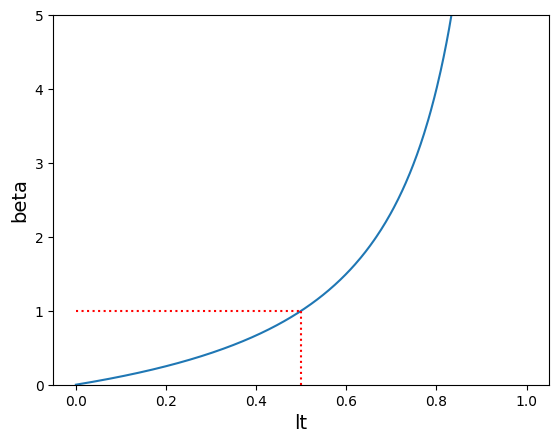

In [38]:
import numpy as np
import matplotlib.pyplot as plt
M = 1000
lambda_ = 1e-6
lt = np.sort(np.random.rand(M))
beta = lt/(1-lt+lambda_)
plt.plot(lt,beta)
plt.ylim(0,5)
plt.vlines(0.5,0,1,linestyles="dotted",color="red")
plt.hlines(1,0,0.5,linestyles="dotted",color="red")
plt.xlabel("lt",fontdict={"fontsize":14})
plt.ylabel("beta",fontdict={"fontsize":14});

> - 8) 依据置信度评估$\beta_t$更新样本权重
>> $w_i = w_i\beta^{(1-L_i)}$<br><br>
>> 我们可以根据$L_i$的范围[0,1]，以及$\beta$的计算公式，绘制出横坐标为$L_i$，纵坐标为$\beta^{(1-L_i)}$的图像。不难发现，**单一样本的损失越大、$\beta^{(1-L_i)}$也会越大，因此该样本的权重会被更新得越大**。<br>

0.3902868424714614 0.6401144497832878


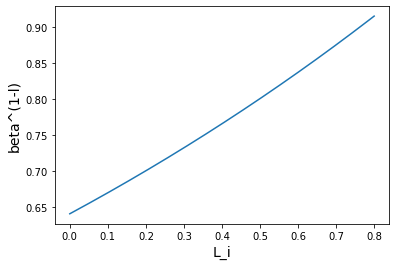

In [298]:
import numpy as np
import matplotlib.pyplot as plt
#假设1000个样本
M = 1000
lambda_ = 1e-6

#1000个样本的损失位于[0,1]之间
l = np.linspace(0,0.8,M)

#1000个样本被抽到的概率加和为1
p = np.random.dirichlet(np.ones(M),size=1)
#p = 1/M

#计算加权平均值与beta
lbar = (l*p).sum()
beta = lbar/(1-lbar+lambda_)

l = np.sort(l,axis=0) #从小到大进行排序

#按照1000个样本的l对beta**(1-l)进行绘图
plt.plot(l,beta**(1-l))
plt.xlabel("L_i",fontdict={"fontsize":14})
plt.ylabel("beta^(1-l)",fontdict={"fontsize":14});
print(lbar, beta)

> - 9) 求解迭代过程中弱分类器$f^t$所需的权重
>> $\phi^t = log(\frac{1}{\beta^t})$\
>> 其中log的底数为e或者为2皆可。当$\beta$值越接近于0，说明损失越小、置信度越高，则$log(\frac{1}{\beta^t})$的值越大。所以，损失更小的树对应的权重更大，损失更大的树对应的权重更小。
> - 10) 求解出当前迭代$t$下集成算法的输出值：
>> $H^t(x_i) = H^{t-1}(x_i) + \eta \phi^t f^t(x_i)$

步骤2~10中循环，直到迭代次数被使用完毕。理想上来说，Adaboost至少应该迭代到$T$次以满足下列条件：

$$\left(\sum_{t:H^t(x) \leq y} log\frac{1}{\beta^t} \right)\ \  \geq \ \ \left(\frac{1}{2}\sum_{t=1}^T log\frac{1}{\beta^t} \right)$$

等同于：
$$\left(\sum_{t:H^t(x) \leq y} \phi^t \right)\ \  \geq \ \ \left(\frac{1}{2}\sum_{t=1}^T \phi^t \right)$$

并且，最终算法的输出值是上述等式满足“等于”条件时所对应的$H^t(x)$。对于一个正常迭代的AdaBoost来说，每一轮迭代后获得的$H(x_i)$都是累加结果，因此$H(x_i)$之间应该满足以下关系：

$$H^0(x_i) < H^1(x_i) <, ... , < H^T(x_i)$$

在$H^0(x_i)$到$H^T(x_i)$过程中，必然只有部分$H(x_i)$是小于真实标签$y_i$的，假设有$t$次迭代中$H(x_i)$都小于$y_i$，则理想状况下，前$t$次迭代中权重的累加，应该大于0.5 * 所有$T$次迭代中权重的累加。当两者相等时，t就是最佳迭代次数，而$t$对应的$H^t(x)$也就是最佳预测值。

要完全使用公式来证明以上式子非常困难，但我们可以通过一个简单的小实验来验证该公式的合理性。

In [39]:
yi = 20
lambda_ = 1e-6

In [40]:
Hx = np.linspace(1,25,1000,endpoint=False) #逐渐增大的Hx

#原则上应该使用fx计算损失，并且在迭代过程中逐渐计算出权重
#但由于计算过程略为复杂，因此我们在这里简化，直接使用Hx计算损失、beta和权重
#这种方法得出的曲线不是最严谨的，但其趋势与使用fx严谨计算的曲线趋势一致
#因为原则上来说，只要一个样本被AdaBoost分类正确，这个样本上的损失应该也是越来越小的
D = np.max(abs(Hx - yi))
L = abs(Hx - yi)/D
beta = L/(1-L+lambda_)

In [41]:
part1 = 0 #用来计算每一轮迭代后的累加值
part1_ = [] #用来保存每一轮迭代后的累加值
part2 = 0
part2_ = []
for t, beta_t in enumerate(beta):
    phi = np.log(1/beta_t)
    #如果Hx小于真实标签yi，则取倒数取对数后放入part1内
    if Hx[t] <= yi:
        part1 += phi
    part1_.append(part1)
    #所有beta取倒数取对数 * 0.5后都放入part2内
    part2 += 0.5*phi
    part2_.append(part2)

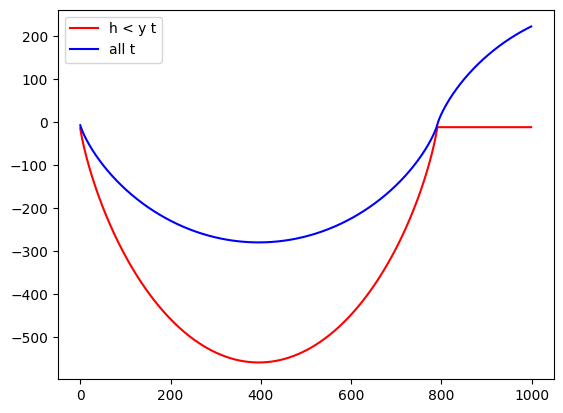

In [42]:
plt.plot(range(len(part1_)),part1_,c="red",label = "h < y t")
plt.plot(range(1000),part2_,c="blue",label = "all t")
plt.legend();

In [43]:
#最佳输出值
Hx[790]

19.96

在课程当中我们专注于AdaBoost回归的讲解，如果你对AdaBoost分类感兴趣，可以在任意材料上找到AdaBoost经典分类方法的数学推导，也可以找到包含了SAMME与SAMME.R方法的数学推导，值得注意的是，在AdaBoost回归方法当中，损失函数并没有明显的被“最小化”的过程，我们借助损失函数来自然地调整数据的权重，从而在迭代中不断减小整体损失，但在AdaBoost分类方法当中，有针对损失函数求解一阶导数、并让一阶导数为0的过程，该过程影响AdaBoost分类过程中求解弱分类器权重的内容，同时也影响AdaBoost分类过程中对于样本权重的迭代更新。感兴趣的小伙伴可以参阅论文《Multi-class AdaBoost》以及sklearn源码(https://github.com/scikit-learn/scikit-learn/blob/0d378913b/sklearn/ensemble/_weight_boosting.py#L913)。

现在，我们已经完整讲解了AdaBoost的回归过程，该过程中的关键步骤可以被推广到任意Boosting算法，相信了解了这个过程之后，在学习后续Boosting算法时，我们将轻松很多。之后，我们将基于该流程讲解后续Boosting算法的原理。